# **1. Data Loading**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from   torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()
"""
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
"""
mnist_data = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
data_loader = torch.utils.data.DataLoader(
    dataset = mnist_data,
    batch_size = 64,
    shuffle = True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.4MB/s]


In [3]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


# **2. Implementing Simple Autoencoder**

In [7]:
class Autoencoder(nn.Module):

  def __init__(self):
    super().__init__()
    # N, 784
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 128), # N, 784 -> N, 128
        nn.ReLU(),
        nn.Linear(128, 64), # N, 128 -> N, 64
        nn.ReLU(),
        nn.Linear(64, 12),  # N, 64 -> N, 12
        nn.ReLU(),
        nn.Linear(12, 3) # N, 12 -> N, 3
    )

    self.decoder = nn.Sequential(
        nn.Linear(3, 12), # N, 3 -> N, 12
        nn.ReLU(),
        nn.Linear(12, 64), # N, 12 -> N, 64
        nn.ReLU(),
        nn.Linear(64, 128), # N, 64 -> N, 128
        nn.ReLU(),
        nn.Linear(128, 28*28), # N, 128 -> N, 784
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded) # Corrected typo here
    return decoded

# Notes: [-1, 1] -> nn.Tanh()

In [8]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [9]:
# Training
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
  for(img,_) in data_loader:
    img = img.reshape(-1, 28*28)
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch: {epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch: 1, Loss:0.0529
Epoch: 2, Loss:0.0393
Epoch: 3, Loss:0.0401
Epoch: 4, Loss:0.0358
Epoch: 5, Loss:0.0389
Epoch: 6, Loss:0.0342
Epoch: 7, Loss:0.0366
Epoch: 8, Loss:0.0372
Epoch: 9, Loss:0.0376
Epoch: 10, Loss:0.0348


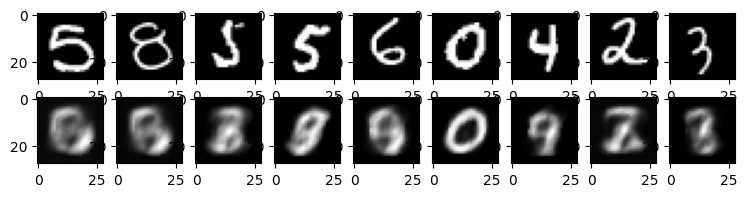

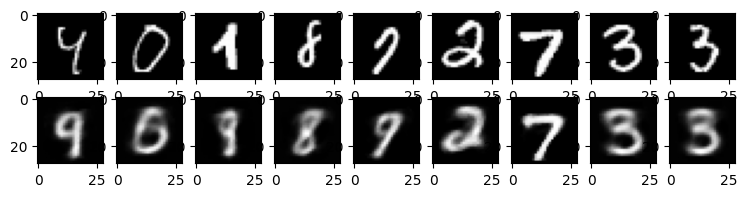

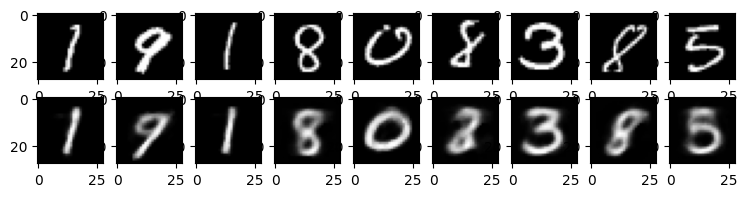

In [10]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9, 2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    item = item.reshape(-1, 28, 28)
    # item: 1, 28, 28
    plt.imshow(item[0])
  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length+i+1
    item = item.reshape(-1, 28, 28)
    # item: 1, 28, 28
    plt.imshow(item[0])

# **3. Implementing CNN Autoencoder**

In [18]:
class CNNAutoencoder(nn.Module):

  def __init__(self):
    super().__init__()
    # N, 1, 28, 28
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, stride = 2, padding = 1), # N, 16, 14, 14
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride = 2, padding = 1), # N, 32, 7, 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7) # N, 64, 1, 1
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7), # N, 32, 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1), # N, 16, 14, 14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride = 2, padding = 1, output_padding = 1), # N, 1, 28, 28
        nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Notes: [-1, 1] -> nn.Tanh()

In [19]:
model = CNNAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

In [20]:
# Training
num_epochs = 10
outputs = []
for epoch in range(num_epochs):
  for(img,_) in data_loader:
    img = img.reshape(-1, 1, 28, 28) # Reshape to [batch_size, channels, height, width]
    recon = model(img)
    loss = criterion(recon, img)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch: {epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch, img, recon))

Epoch: 1, Loss:0.0100
Epoch: 2, Loss:0.0057
Epoch: 3, Loss:0.0047
Epoch: 4, Loss:0.0039
Epoch: 5, Loss:0.0034
Epoch: 6, Loss:0.0034
Epoch: 7, Loss:0.0030
Epoch: 8, Loss:0.0031
Epoch: 9, Loss:0.0029
Epoch: 10, Loss:0.0029


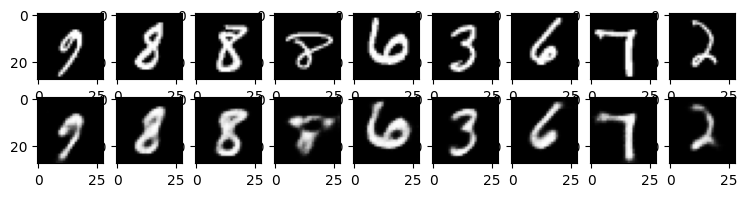

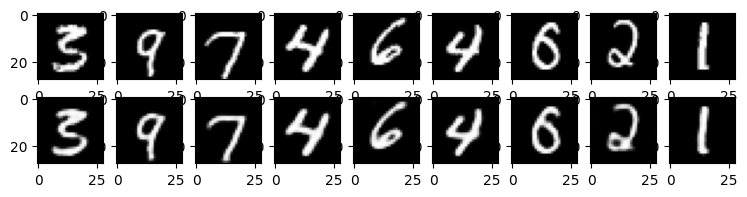

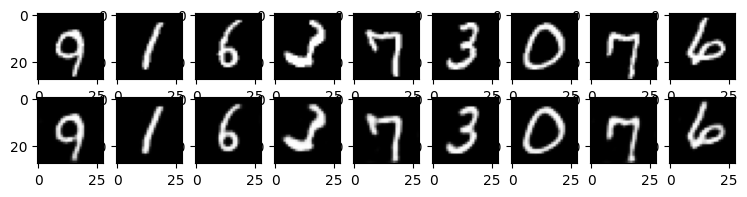

In [21]:
for k in range(0, num_epochs, 4):
  plt.figure(figsize=(9, 2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9: break
    plt.subplot(2, 9, i+1)
    item = item.reshape(-1, 28, 28)
    # item: 1, 28, 28
    plt.imshow(item[0])
  for i, item in enumerate(recon):
    if i >= 9: break
    plt.subplot(2, 9, 9+i+1) # row_length+i+1
    item = item.reshape(-1, 28, 28)
    # item: 1, 28, 28
    plt.imshow(item[0])